In [19]:
%%capture
!pip install einops pytorch_lightning diffusers==0.12.1 kornia accelerate librosa

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src_old import *

mpl.rcParams['figure.figsize'] = (8, 8)

In [3]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 target_dir,
                 condition_dir=None,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.target_dir = target_dir
        self.condition_dir = condition_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg','png']        
        self.files=[el for el in os.listdir(self.target_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        target_name = os.path.join(self.target_dir, self.files[idx])
        condition_name = os.path.join(self.condition_dir, self.files[idx])
        
        target_image = image_to_tensor(io.imread(target_name))/255
        condition_image = image_to_tensor(io.imread(condition_name))/255
        
        # Copying spectrogram to three channels
        target_image = target_image.repeat(3,1,1)
        condition_image = condition_image.repeat(3,1,1)

        if self.paired:
            if self.transforms is not None:
                out = self.input_T(target_image,condition_image)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            target_image = self.input_T(target_image)[0]

        if self.return_pair:
            return condition_image, target_image
        else:
            return target_image

torch.Size([3, 256, 256])


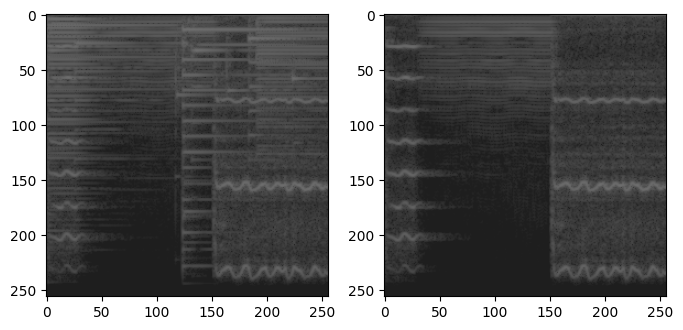

In [33]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=3
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=3
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=3
                     )

img1,img2=test_ds[0]

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

print(img1.shape)

In [5]:
model=LatentDiffusionConditional(train_ds,
                                 valid_dataset = valid_ds,
                                 lr=1e-4,
                                 batch_size=8)

Is Time embed used ?  True


Text(0.5, 1.0, 'AutoEncoder Reconstruction')

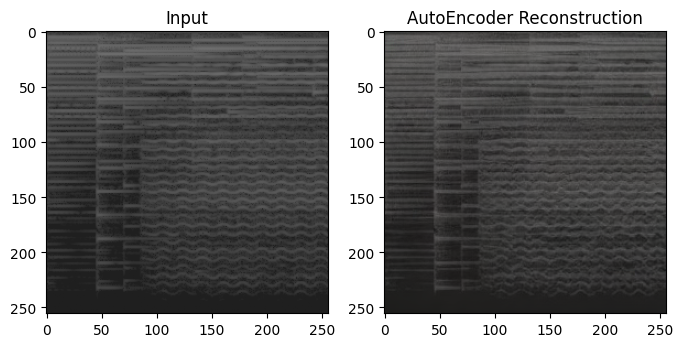

In [6]:
plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(model.ae(img1.unsqueeze(0))[0].detach().cpu().permute(1,2,0))
plt.title('AutoEncoder Reconstruction')

In [7]:
trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)]
)

/notebooks/src_old/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | ae    | AutoEncoder                          | 83.7 M
1 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
140 M     Trainable params
0         Non-trainable params
140 M     Total params
561.105   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
trainer.fit(model, ckpt_path='lightning_logs/version_16/checkpoints/epoch=113-step=7182.ckpt')

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /notebooks/lightning_logs/version_17/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at lightning_logs/version_16/checkpoints/epoch=113-step=7182.ckpt


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:44 in                   │
│ _call_and_handle_interrupt                                                                       │
│                                                                                                  │
│    41 │   │   if trainer.strategy.launcher is not None:                                          │
│    42 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│    43 │   │   else:                                                                              │
│ ❱  44 │   │   │   return trainer_fn(*args, **kwargs)                                             │
│    45 │                                                                                          │
│    46 │   except _TunerExitException:                                                            │
│    47 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:559 in _fit_impl     │
│                                                                                                  │
│    556 │   │   │   model_provided=True,                                                          │
│    557 │   │   │   model_connected=self.lightning_module is not None,                            │
│    558 │   │   )                                                                                 │
│ ❱  559 │   │   self._run(model, ckpt_path=ckpt_path)                                             │
│    560 │   │                                                                                     │
│    561 │   │   assert self.state.stopped                                                         │
│    562 │   │   self.training = False                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:901 in _run          │
│                                                                                                  │
│    898 │   │   # check if we should delay restoring checkpoint till later                        │
│    899 │   │   if not self.strategy.restore_checkpoint_after_setup:                              │
│    900 │   │   │   log.debug(f"{self.__class__.__name__}: restoring module and callbacks from c  │
│ ❱  901 │   │   │   self._checkpoint_connector._restore_modules_and_callbacks(ckpt_path)          │
│    902 │   │                                                                                     │
│    903 │   │   log.debug(f"{self.__class__.__name__}: configuring sharded model")                │
│    904 │   │   call._call_configure_sharded_model(self)  # allow user to setup in model sharded  │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector │
│ .py:395 in _restore_modules_and_callbacks                                                        │
│                                                                                                  │
│   392 │                                                                                          │
│   393 │   def _restore_modules_and_callbacks(self, checkpoint_path: Optional[_PATH] = None) ->   │
│   394 │   │   # restore modules after setup                                                      │
│ ❱ 395 │   │   self.resume_start(checkpoint_path)                                                 │
│   396 │   │   self.restore_model()                         

In [31]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

model.cuda()
out=model(batch_input, verbose=True)

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

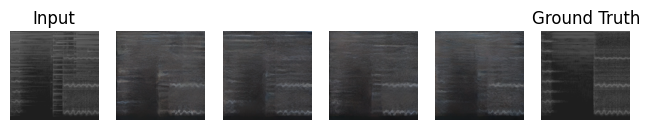

In [32]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')